## Installing and importing all the essential libraries..

In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.0 MB/s eta 0:00:00


In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
from torch import nn
from torch.optim import Adam
from transformers import GPT2Model, GPT2Tokenizer
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [4]:
import pandas as pd

# Reading the dataset from the drive..
the dataset as mentioned in the github repo is taken from kaggle

link: (https://www.kaggle.com/datasets/nikhileswarkomati/suicide-watch)

In [5]:
df = pd.read_csv('/content/drive/MyDrive/project_dataset/Suicide_Detection.csv')

In [6]:
df.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [7]:
df.drop('Unnamed: 0',axis=1,inplace=True)

# Checking if there is any uneven distribution in the number of records for each class..

This is a really important step in binary classification because if this there is skewness in the data, the model will not be able to understand the relations in the data and rather will give the output for all the inputs as the class to which the data is skewed..

<Axes: xlabel='class'>

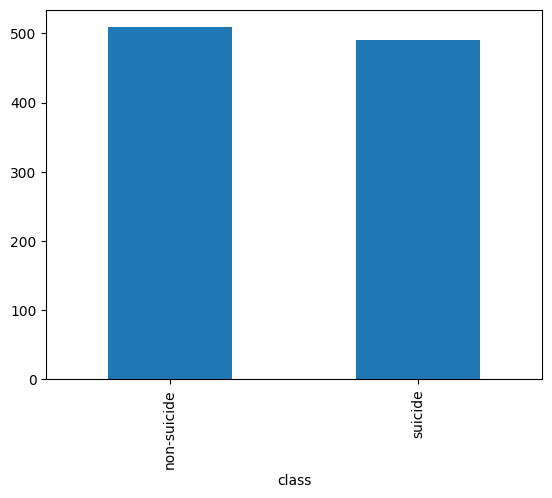

In [8]:
df.groupby("class").size().plot.bar()

# Tokenizing the data

Initially I tried with traditional bag of words tokenizing.. but this is really inefficient when compared to that of tokenizers that can be taken out from HuggingFaces..

Here I am using GPT2 tokenizer

In [9]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

In [10]:
example_text = df['text'][0]
gpt2_input = tokenizer(example_text, padding="max_length", max_length=100, truncation=True, return_tensors="pt")

To understand how the tokenizing is going on we can look into this example..

In [11]:
print(example_text)

Ex Wife Threatening SuicideRecently I left my wife for good because she has cheated on me twice and lied to me so much that I have decided to refuse to go back to her. As of a few days ago, she began threatening suicide. I have tirelessly spent these paat few days talking her out of it and she keeps hesitating because she wants to believe I'll come back. I know a lot of people will threaten this in order to get their way, but what happens if she really does? What do I do and how am I supposed to handle her death on my hands? I still love my wife but I cannot deal with getting cheated on again and constantly feeling insecure. I'm worried today may be the day she does it and I hope so much it doesn't happen.


In [12]:
print(gpt2_input['input_ids'])

tensor([[ 3109, 34188, 25238,  3101, 27695, 24661,   314,  1364,   616,  3656,
           329,   922,   780,   673,   468, 37264,   319,   502,  5403,   290,
         19837,   284,   502,   523,   881,   326,   314,   423,  3066,   284,
         11148,   284,   467,   736,   284,   607,    13,  1081,   286,   257,
          1178,  1528,  2084,    11,   673,  2540, 11123,  7341,    13,   314,
           423, 47905,  3377,   777, 14187,   265,  1178,  1528,  3375,   607,
           503,   286,   340,   290,   673,  7622, 10818, 21712,   780,   673,
          3382,   284,  1975,   314,  1183,  1282,   736,    13,   314,   760,
           257,  1256,   286,   661,   481, 16180,   428,   287,  1502,   284,
           651,   511,   835,    11,   475,   644,  4325,   611,   673,  1107]])


In [13]:
print(gpt2_input["attention_mask"])

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]])


Preparing the dataset..

In [14]:
df = pd.read_csv('/content/drive/MyDrive/project_dataset/Suicide_Detection.csv', nrows=100)

In [15]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
labels = {
    "suicide":1,
    "non-suicide": 0,
         }

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.labels = [labels[label] for label in df['class']]
        self.texts = [tokenizer(text,
                                padding='max_length',
                                max_length=128,
                                truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

In [16]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=35),
                                     [int(0.8*len(df)), int(0.9*len(df))])


In [17]:
class SimpleGPT2SequenceClassifier(nn.Module):
    def __init__(self, hidden_size: int, num_classes:int ,max_seq_len:int, gpt_model_name:str):
        super(SimpleGPT2SequenceClassifier,self).__init__()
        self.gpt2model = GPT2Model.from_pretrained(gpt_model_name)
        self.fc1 = nn.Linear(hidden_size*max_seq_len, num_classes)


    def forward(self, input_id, mask):
        gpt_out, _ = self.gpt2model(input_ids=input_id, attention_mask=mask, return_dict=False)
        batch_size = gpt_out.shape[0]
        linear_output = self.fc1(gpt_out.view(batch_size,-1))
        return linear_output

# Training the model...
this is just for showcase purpose.. acutal training was done with the entire dataset.

In [18]:
def train(model, train_data, val_data, learning_rate, epochs):
    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0

        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input["input_ids"].squeeze(1).to(device)

            model.zero_grad()

            output = model(input_id, mask)

            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()

            acc = (output.argmax(dim=1)==train_label).sum().item()
            total_acc_train += acc

            batch_loss.backward()
            optimizer.step()

        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():

            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()

                acc = (output.argmax(dim=1)==val_label).sum().item()
                total_acc_val += acc

            print(
            f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train/len(train_data): .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / len(val_data): .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f}")

EPOCHS = 1
model = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=2, max_seq_len=128, gpt_model_name="gpt2")
LR = 1e-5

train(model, df_train, df_val, LR, EPOCHS)

100%|██████████| 40/40 [00:07<00:00,  5.64it/s]


Epochs: 1 | Train Loss:  0.528             | Train Accuracy:  0.637             | Val Loss:  0.364             | Val Accuracy:  0.500


# Evaluating the model

In [19]:
def evaluate(model, test_data):
    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    if use_cuda:
        model = model.cuda()

    # Tracking variables
    predictions_labels = []
    true_labels = []
    total_acc_test = 0
    with torch.no_grad():
        for test_input, test_label in test_dataloader:
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)
            output = model(input_id, mask)
            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
            true_labels += test_label.cpu().numpy().flatten().tolist()
            predictions_labels += output.argmax(dim=1).cpu().numpy().flatten().tolist()

    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return true_labels, predictions_labels

true_labels, pred_labels = evaluate(model, df_test)

Test Accuracy:  1.000


Another good gauge of model performance is the confusion matrix.

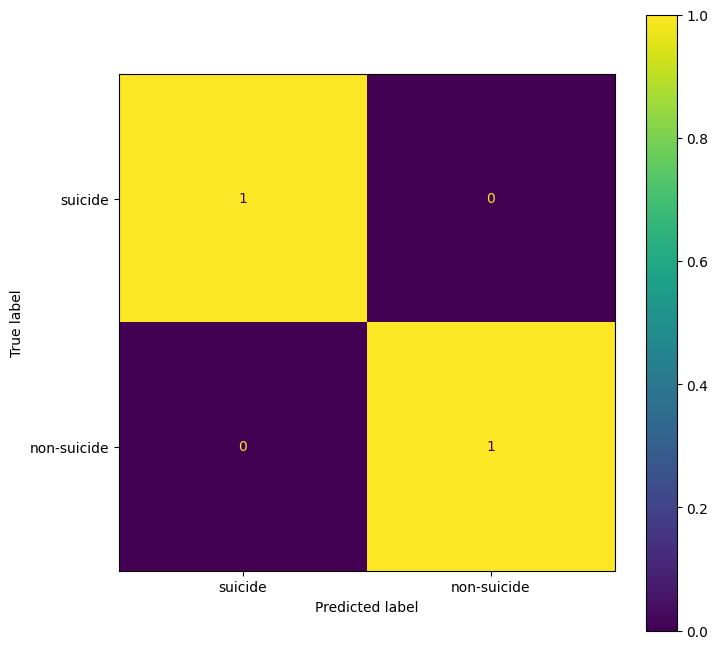

In [20]:
# Plot confusion matrix.
fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(labels)), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(labels.keys()))
disp.plot(ax=ax)

# Storing the weights of the model for later use in the API..

In [21]:
torch.save(model.state_dict(), "/content/predict.pt")

# Loading the weights to the model for testing purpose..

In [24]:
# load trained model
model_new = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=2, max_seq_len=128, gpt_model_name="gpt2")
model_new.load_state_dict(torch.load("/content/predict.pt"))
model_new.eval()

SimpleGPT2SequenceClassifier(
  (gpt2model): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (fc1): Linear(in_features=98304, out_features=2, bias=True)
)

In [26]:
example_text = input("ENTER A SAMPLE TEXT: ")
fixed_text = " ".join(example_text.lower().split())
print(fixed_text)

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

model_input = tokenizer(fixed_text, padding='max_length', max_length=128, truncation=True, return_tensors="pt")

ENTER A SAMPLE TEXT: I wanna live ever after
i wanna live ever after


In [28]:
mask = model_input['attention_mask'].cpu()
input_id = model_input["input_ids"].squeeze(1).cpu()

output = model_new(input_id, mask)

In [29]:
print(output)

tensor([[-1.3136, -1.9020]], grad_fn=<AddmmBackward0>)


In [30]:
prob = torch.nn.functional.softmax(output, dim=1)[0]

In [31]:
print(prob)

tensor([0.6430, 0.3570], grad_fn=<SelectBackward0>)


# Final output.. and it works

In [32]:
labels_map = {
    0: "non-suicidal",
    1: "suicidal",
         }

pred_label = labels_map[output.argmax(dim=1).item()]
print(pred_label)

non-suicidal
